# Regressão Logística nos dados covtype de LIBSVM

Iremos treinar os dados para classificação binária usando os dados `covtype` da biblioteca [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). Veja também [Kaggle-LIBSVM](https://www.kaggle.com/code/tanmayunhale/libsvm-liblinear).

Queremos minimizar

$$
\min_{w\in {\mathbb R}^{d\times1}} f(w)=-\frac{1}{n}\sum_{i=1}^n \left(y_i \log (s(x_i^\top w)) + (1 - y_i) \log (1 - s(x_i^\top w))\right) + \frac{\gamma}{2}\|w\|^2,
$$

onde $x_i\in {\mathbb R}^{d\times1}$, $y_i\in \{0, 1\}$, $s(z)=\frac{1}{1+\exp(-z)}$ é a função sigmóide. O gradiente é dado por

$$
\nabla f(w) = \frac{1}{n}\sum_{i=1}^n x_i(s(x_i^\top w)-y_i) + \gamma w.
$$

Esta é uma função suave com constante de Lipschitz $L=L_0+\gamma$ onde

$$
L_0 = \frac{1}{4}\lambda_{\max}\left(\frac{X^\top X}{n}\right),
$$ 

onde $X\in\mathbb{R}^{n\times d}$ é a matriz de dados cuja $i$-ézima linha é o vetor $x_i^\top$ e $\lambda_{\max}(\cdot)$ denota o maior autovalor.

In [1]:
# Importação de módulos necesserários:

import matplotlib
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file
from sklearn.utils.extmath import safe_sparse_dot

In [2]:
# Lendo os dados do arquivo covtype e guardando na matriz de dados X e vetor de labels y:

data = load_svmlight_file('./datasets/covtype')
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Devemos garantir que os labels estão em {0, 1}
    y -= 1    
    
n, d = X.shape # tamanho da amostra, número de features    

# Exercício 1: Funções auxiliares

1. Construa uma função `smoothness(X)` que toma a matriz de dados `X` e retorna a constante $L_0$.
2. Construa uma função `f(w, X, y, l2)` que toma o iterado `w`, os dados `X, y` e a penalização $\gamma$ (=`l2`) e retorna o valor funcional $f(w)$.
3. Construa uma função `df(w, X, y, l2)` toma o iterado `w`, os dados `X, y` e a penalização $\gamma$ (=`l2`) e retorna o gradiente $\nabla f(w)$.

In [3]:
#Escreva código aqui
def smoothness(X):
    aux = (X.T @ X)/X.shape[0]
    L0 = (1/4) * np.max(la.eigvals(aux))
    return L0

# Função auxiliar para calcular a função sigmoide
def s(z):
    return 1/(1 + np.exp(-z))

def f(w, X, y, l2):
    aux1 = (-1/n) * np.sum(y * np.log(s(X @ w)) + (1 - y) * np.log(1 - s(X @ w)))
    aux2 = (l2/2) * (la.norm(w) ** 2)
    return aux1 + aux2

def df(w, X, y, l2):
    grad = (1/n) * np.sum(X * (s(X @ w) - y)[:, np.newaxis], axis = 0) + l2 * w
    return grad

# Inicialização

Fixaremos:

In [4]:
L0 = smoothness(X)
l2 = L0 / n
L = L0 + l2
w0 = np.zeros(d)        # ponto inicial
it_max = 10000          # número de iterações

#Função de desempenho é a norma de Frobenius:
J = lambda w: la.norm(w)

#Função que retorna gradiente (para X,y,l2) já declarados.
def Df(w):
    return df(w, X, y, l2)

l2

8.67636767288071

# Exercício 2: Método do gradiente

Construa uma função `gd(df, w0, la=1, numb_iter=100)` que toma como entrada as funções `J()` `df()`, o ponto inicial `w0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente iniciando de `w0`. Esta função deve retornar a sequência de valores da função $\Vert\nabla f(w)\Vert_2$ em cada um dos iterados $w$. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L` 

In [5]:
#Escreva código aqui
def gd(J, df, w0, la = 1, numb_iter = 100):
    # Inicializando o histórico de erros
    error_history = []
    # Inicializando w como w0
    w = w0.copy()

    # Calculando o gradiente
    grad = df(w)
    # Calculando o erro como sua norma
    error = J(grad)
    # Salvando o erro
    error_history.append(error)

    # Em cada iteração...
    for _ in range(numb_iter):
        # Avança o w
        w -= la * grad

        # Calcula o novo gradiente
        grad = df(w)
        # Calcula o novo erro
        error = J(grad)
        # Salva o novo erro
        error_history.append(error)

    return error_history, w

In [6]:
# gradient descent
f1 = gd(J, Df, w0, la=1./L, numb_iter=it_max)

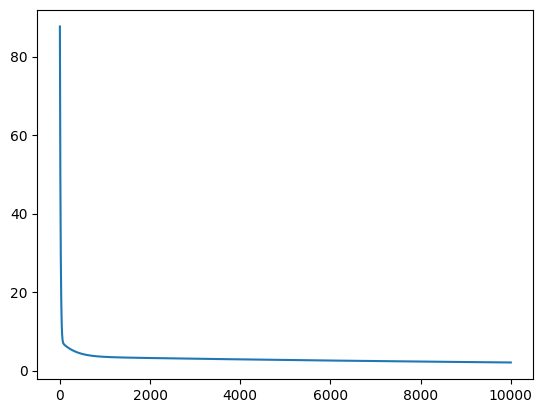

In [7]:
plt.plot(f1[0])

# Exercício 3: Método do gradiente acelerado

Construa uma função `accel_gd(J, df, w0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df()`, o ponto inicial `w0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `w0` e $t_0=1$:
\begin{align*}
w_{k+1}&:= y_k - la\nabla f(y_k),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
y_{k+1} &:= w_{k+1} + \frac{t_{k}-1}{t_{k+1}}(w_{k+1}-w_{k}).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L`.

In [8]:
#Escreva código aqui
def accel_gd(J, df, w0, la = 1, numb_iter = 100):
    # Inicializando o histórico de erros
    error_history = []

    # Inicializando wk como uma cópia do w0
    wk = w0.copy()
    # Inicializando y e tk
    y = wk
    tk = 1

    # Calculando o gradiente
    grad = df(y)
    # Calculando o erro como sua norma
    error = J(grad)
    # Salvando o erro
    error_history.append(error)

    # Em cada iteração...
    for _ in range(numb_iter):
        # Atualiza o wk1
        wk1 = y - la * grad
        # Atualiza o tk1
        tk1 = (1 + np.sqrt(1 + 4 * tk ** 2))/2
        # Atualiza o y
        y = wk1 + ((tk - 1)/tk1) * (wk1 - wk)

        # Calcula o gradiente
        grad = df(y)
        # Calcula o erro
        error = J(grad)
        # Salva o erro
        error_history.append(error)

        # Avança o wk e o tk
        wk = wk1
        tk = tk1

    return error_history, y

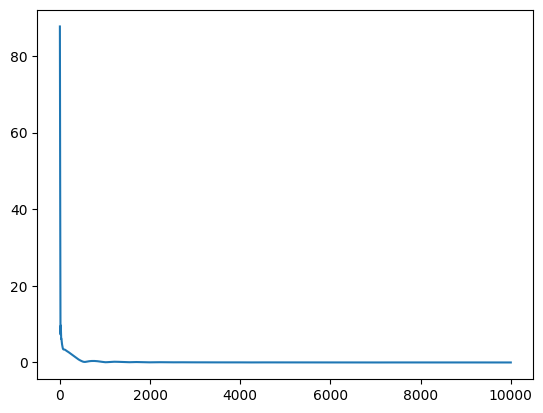

In [10]:
# Nesterov accelerated gradient descent
f2 = accel_gd(J, Df, w0, la=1./L, numb_iter=it_max)
plt.plot(f2[0])

# Exercício 4: Método do gradiente acelerado com $\gamma$

Construa uma função `accel_gd_sc(J, df, w0, la=1, kappa, numb_iter=100)` que toma como entrada as funções `J()`, `df()`, o ponto inicial `w0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `y0=w0`:
\begin{align*}
w_{k+1}&:= y_k - la\nabla f(y_k),\\
y_{k+1} &:= w_{k+1} + \frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}(w_{k+1}-w_{k}).
\end{align*}
Àcima, $\kappa:=L/\gamma$. Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L`.

In [11]:
#Escreva código aqui
def accel_gd_sc(J, df, w0, kappa, la = 1, numb_iter = 100):
    # Inicializando o histórico de erros
    error_history = []
    
    # Inicializando y e wk
    y = w0.copy()
    wk = w0.copy()

    # Calculando o gradiente
    grad = df(y)
    # Calculando o erro como sua norma
    error = J(grad)
    # Salvando o erro
    error_history.append(error)

    # Em cada iteração...
    for _ in range(numb_iter):
        # Atualiza o wk1 e o y
        wk1 = y - la * grad
        y = wk1 + ((np.sqrt(kappa) - 1)/(np.sqrt(kappa) + 1)) * (wk1 - wk)

        # Calcula o gradiente
        grad = df(y)
        # Calcula o erro
        error = J(grad)
        # Salva o erro
        error_history.append(error)

        # Avança o wk
        wk = wk1

    return error_history, y

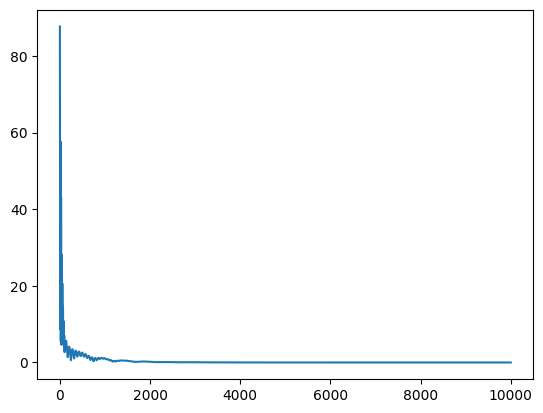

In [12]:
# Nesterov accelerated gradient descent for strongly convex functions
f3 = accel_gd_sc(J, Df, w0, la=1./L, kappa=L/l2, numb_iter=it_max)
plt.plot(f3[0])

# Exercício 5: Adagrad-Norm

Construa uma função `ad_grad_norm(J, Df, w0, b0=0.5, eta=1, numb_iter=100)` que toma como entrada as funções `J()`, `Df`, o ponto inicial `w0`, parametros positivos `b0` e `eta` e o número de iterações `numb_iter` e implementa o método Adagrad-Norm iniciando de `w0`:
\begin{align*}
w_{k+1}&:= w_k - \frac{\eta}{\sqrt{b_0^2 + \sum_{j=1}^k\Vert\nabla f(w_j)\Vert_2^2}} \nabla f(w_k).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(Df(w))` em cada um dos iterados `w`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `b0=0.5` e `eta=1`.

In [13]:
#Escreva código aqui
def ad_grad_norm(J, Df, w0, b0 = 0.5, eta = 1, numb_iter = 100):
    # Inicializando o histórico de erros
    error_history = []
    # Inicializando a soma dos quadrados das normas dos gradientes
    grads_sum = 0

    # Criando uma cópia do x0
    w = w0.copy()

    # Calculando o gradiente e sua norma
    grad = Df(w)
    error = J(grad)
    # Salvando o erro
    error_history.append(error)
    # Incrementando a soma das normas dos gradientes
    grads_sum += error**2

    # Em cada iteração...
    for _ in range(numb_iter):
        # Atualiza o w
        w -= (eta/(np.sqrt(b0**2 + grads_sum))) * grad

        # Calcula o gradiente e sua norma
        grad = Df(w)
        error = J(grad)
        # Salva o erro
        error_history.append(error)
        # Incrementa a soma das normas dos gradientes
        grads_sum += error**2

    return error_history, w

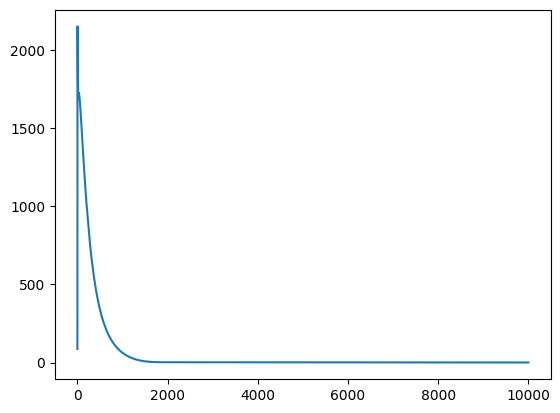

In [14]:
# Adagrad-Norm
f4 = ad_grad_norm(J, Df, w0, b0=0.5, eta=0.01, numb_iter=it_max)
plt.plot(f4[0])

# Exercício 6: Adam

Construa uma função `adam(Df, w0, alpha, beta1, beta2, epsilon, numb_iter)` que toma como entrada as funções `Df`, o ponto inicial `w0`, parametros positivos `alpha`, `beta1`, `beta2`, `epsilon` e o número de iterações `numb_iter` e implementa o método Adam iniciando de `w0`, $m_0=0$, $v_0=0$ e $k=0$: para cada $j$ézima coordenada:
\begin{align*}
m_{k+1}[j] &:= \beta_1\cdot m_{k}[j] + (1-\beta_1)\cdot\nabla f(w_k)[j],\\
v_{k+1}[j] &:= \beta_2\cdot v_{k}[j] + (1-\beta_2)\cdot(\nabla f(w_k)[j])^2,\\
\hat m_{k+1}[j] &:= \frac{1}{1-\beta_1^{k+1}}m_{k+1}[j],\\
\hat v_{k+1}[j] &:= \frac{1}{1-\beta_2^{k+1}}v_{k+1}[j],\\
w_{k+1}[j] &:= w_{k}[j] - \frac{\alpha}{\sqrt{\hat v_{k+1}[j]} + \epsilon }\hat m_{k+1}[j].
\end{align*}
Esta função deve retornar a sequência de valores da função `J(Df(w))` em cada um dos iterados `w`, isto é, a sequência das normas dos gradientes de $w_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `alpha=0.001`, `beta1=0.9`, `beta2=0.999`, `epsilon=10**(-8)`. 

In [15]:
#Escreva código aqui
def adam(Df, w0, alpha, beta1, beta2, epsilon, numb_iter):
    # Inicializando o histórico de erros
    error_history = []

    # Criando uma cópia do w0
    w = w0.copy()
    # Inicializando as variáveis
    m = 0
    v = 0

    # Calculando o gradiente e sua norma
    grad = Df(w)
    error = J(grad)
    # Salvando o erro
    error_history.append(error)

    # Em cada iteração...
    for k in range(numb_iter):
        # Atualiza as variáveis
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2
        m_hat = (1/(1 - beta1**(k + 1))) * m
        v_hat = (1/(1 - beta2**(k + 1))) * v
        w -= (alpha/(np.sqrt(v_hat) + epsilon)) * m_hat

        # Calcula o gradiente e sua norma
        grad = Df(w)
        error = J(grad)
        # Salva o erro
        error_history.append(error)

    return error_history, w

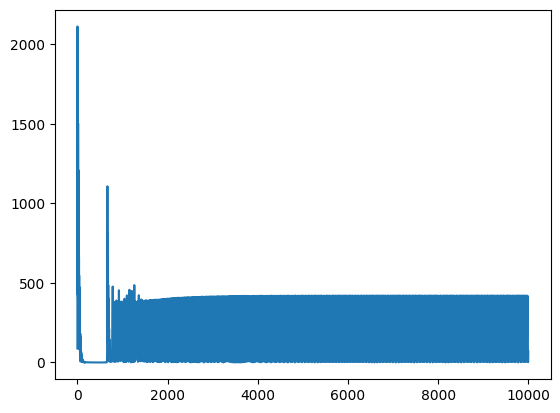

In [16]:
# Adam
f5 = adam(Df, w0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8), numb_iter=it_max)
plt.plot(f5[0])

# Exercício 7: 

Implemente num mesmo gráfico os erros $\Vert\nabla f(w_k)\Vert$ de cada método em função no número de iterações.

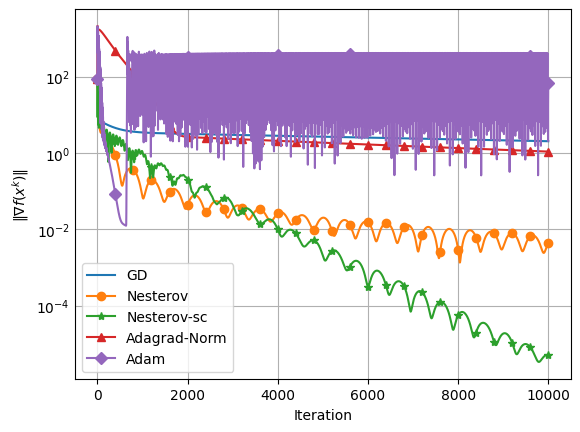

In [17]:
#Escreva código aqui
def plot_errors(f1, f2, f3, f4, f5):
    # Plotando as linhas
    plt.plot(f1[0], label = "GD")
    plt.plot(f2[0], label = "Nesterov", marker = "o", markevery = 400)
    plt.plot(f3[0], label = "Nesterov-sc", marker = "*", markevery = 400)
    plt.plot(f4[0], label = "Adagrad-Norm", marker = "^", markevery = 400)
    plt.plot(f5[0], label = "Adam", marker = "D", markevery = 400)
    # Ajustando os eixos
    plt.xlabel("Iteration")
    plt.yscale("log")
    plt.ylabel(r"$\|\nabla f(x^k)\|$")
    plt.tick_params(axis = "y", which = "both", length = 0)
    # Ativando a legenda e o grid
    plt.legend()
    plt.grid(True)

plot_errors(f1, f2, f3, f4, f5)

# Exercício 8:

Experimente com os hyper-parâmetros de Adagrad-Norm and Adam para ver se eles podem chegar perto ou superar a performance de GD e Nesterov. Plote o gráfico como no Exercício 7. 

In [ ]:
# TESTANDO HIPERPARÂMETROS DO ADAGRAD-NORM

# Inicializando variáveis para armazenar os melhores resultados
best_b0 = 0
best_eta = 0
best_error = np.infty

# Valores a serem testados
b0s = [0.1, 0.5, 1]
etas = [0.01, 0.1, 1]

# Para cada valor candidato de b0...
for b0 in b0s:
    # Para cada valor candidado de eta...
    for eta in etas:
        # Calcula o erro final do modelo
        final_error = ad_grad_norm(J, Df, w0, b0, eta, numb_iter=1000)[0][-1]
        # Se for menor que o melhor erro até agora...
        if final_error < best_error:
            # Salva essa configuração como a melhor até agora
            best_error = final_error
            best_b0 = b0
            best_eta = eta

print("Best b0: ", best_b0)
print("Best eta: ", best_eta)

C:\Users\pedro\AppData\Local\Temp\ipykernel_1320\1258737562.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


Best b0:  1
Best eta:  0.01


In [ ]:
# Rodando o modelo com os melhores parâmetros encontrados
g4 = ad_grad_norm(J, Df, w0, best_b0, best_eta, numb_iter=it_max)

In [ ]:
# TESTANDO HIPERPARÂMETROS DO ADAM

# Inicializando variáveis para armazenar os melhores resultados
best_alpha = 0
best_beta1 = 0
best_beta2 = 0
best_epsilon = 0
best_error = np.infty

# Valores a serem testados
alphas = [0.0005, 0.001]
beta1s = [0.85, 0.9]
beta2s = [0.995, 0.999]
epsilons = [10**(-8), 10**(-6)]

# Para cada valor candidato de alpha...
for alpha in alphas:
    # Para cada valor candidado de b1...
    for beta1 in beta1s:
        # # Para cada valor candidato de b2...
        for beta2 in beta2s:
            # Para cada valor candidato de epsilon...
            for epsilon in epsilons:
                # Calcula o erro final do modelo
                final_error = adam(Df, w0, alpha, beta1, beta2, epsilon, numb_iter=1000)[0][-1]
                # Se for menor que o melhor erro até agora...
                if final_error < best_error:
                    # Salva essa configuração como a melhor até agora
                    best_error = final_error
                    best_alpha = alpha
                    best_beta1 = beta1
                    best_beta2 = beta2
                    best_epsilon = epsilon

print("Best alpha: ", best_alpha)
print("Best beta1: ", best_beta1)
print("Best beta2: ", best_beta2)
print("Best epsilon: ", best_epsilon)

Best alpha:  0.001
Best beta1:  0.85
Best beta2:  0.995
Best epsilon:  1e-08


In [ ]:
# Rodando o modelo com os melhores parâmetros encontrados
g5 = adam(Df, w0, best_alpha, best_beta1, best_beta2, best_epsilon, numb_iter=it_max)

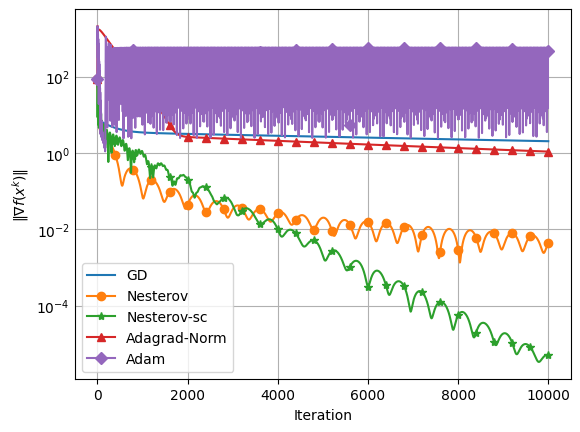

In [ ]:
# Plotando os erros dos modelos com melhores hiperparâmetros
plot_errors(f1, f2, f3, g4, g5)